In [1]:
import pylab
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import algorithms as algo

In [2]:
import pandas as pd
dataset='datasets/export'
files = ["L185_0_A9_1", "L185_0_A10_1", "L186_0_A11_1","L186_0_A12_1",
         "L187_0_B1_1", "L187_0_B2_1",  "L291_0_A1_1", "L291_0_A2_1",
        ]
i = 2
print(f"{dataset}/{files[i]}.txt")
df= pd.read_table(f"{dataset}/{files[i]}.txt",
                  sep=" ", 
                  header=None,
                  names=['m/z', 'intensity']) 
df.head()

datasets/export/L186_0_A11_1.txt


,m/z,intensity
0,997.552,6966
1,997.646,6942
2,997.741,7003
3,997.836,7068
4,997.931,7122


In [3]:
x = df['m/z'].to_numpy()
y = df['intensity'].to_numpy()
print(x[:5])
print(y[:5])

[997.552 997.646 997.741 997.836 997.931]
[6966 6942 7003 7068 7122]


# SciPy: scipy.signal.find_peaks
- `height` : Required height of peaks.
- `distance`: Required threshold of peaks, the vertical distance to its neighboring samples.
- `prominence`: Required minimal horizontal distance (>= 1) in samples between neighbouring peaks
- `threshold` : Required prominence of peaks.
- `width`: Required width of peaks in samples
- `wlen` : Used for calculation of the peaks prominences, if one of `prominence` or `width` is given.
- `rel_height`: Used for calculation of the peaks width, if `width` is given.
- `plateau_size`: Required size of the flat top of peaks in samples.

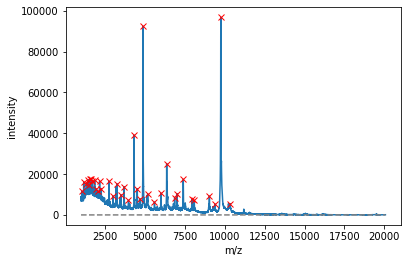

In [4]:
dist, prom = 500, 3000
peaks,_ = signal.find_peaks(y, distance=dist, prominence=prom)
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, y)
plt.plot(x[peaks], y[peaks], "rx")
plt.plot(x,np.zeros_like(y), "--", color="gray")
plt.show()

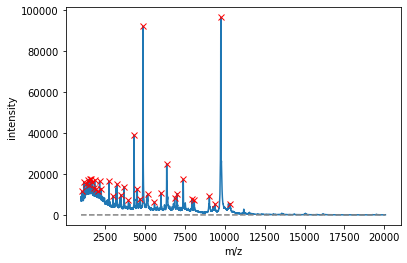

In [5]:
window = 15
deg = 2   
smoothed = signal.savgol_filter(y, window, deg, deriv=0)
peaks,_ = signal.find_peaks(smoothed, distance=dist, prominence=prom)

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, smoothed)
plt.plot(x[peaks], smoothed[peaks], "rx")
plt.plot(x, np.zeros_like(y), "--", color="gray")
plt.show()

# Baseline Correction

## pybaselines · PyPI
cf. https://github.com/derb12/pybaselines <br> 
A Python library of algorithms for the baseline correction of experimental data. `pybaselines` has 50+ baseline correction algorithms. 
- Polynomial methods (`pybaselines.polynomial`), 
- Whittaker-smoothing-based methods (`pybaselines.whittaker`), 
- Morphological methods (`pybaselines.morphological`), 
- Spline methods (`pybaselines.spline`) 
- Smoothing-based methods (`pybaselines.smooth`)
- Baseline/Peak Classification methods (`pybaselines.classification`)
- Optimizers (`pybaselines.optimizers`)
- Miscellaneous methods (`pybaselines.misc`)

In [6]:
# Erb, D. (2022). pybaselines: A Python library of algorithms for the baseline correction of experimental data. 
# https://doi.org/10.5281/zenodo.5608581.
   
from pybaselines import Baseline, utils

In [7]:
baseline_fitter = Baseline(x_data=x)
bkg_1 = baseline_fitter.modpoly(y, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(y, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(y, half_window=30)[0]
bkg_4 = baseline_fitter.snip(
    y, max_half_window=40, decreasing=True, smooth_half_window=3
)[0]

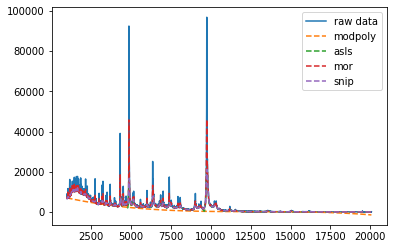

In [8]:
plt.plot(x, y, label='raw data', lw=1.5)
plt.plot(x, bkg_1, '--', label='modpoly')
plt.plot(x, bkg_2, '--', label='asls')
plt.plot(x, bkg_3, '--', label='mor')
plt.plot(x, bkg_4, '--', label='snip')
plt.legend()
plt.show()

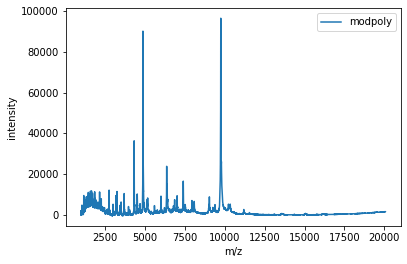

In [9]:
plt.plot(x, y - bkg_1, label='modpoly')
plt.legend()
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

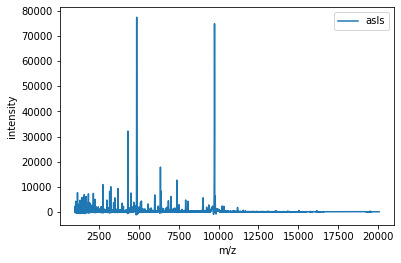

In [10]:
plt.plot(x, y-bkg_2, label='asls')
plt.legend()
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

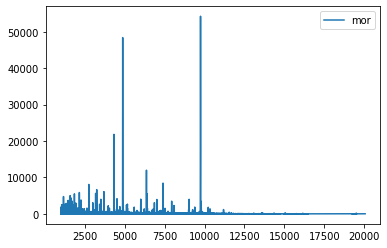

In [11]:
plt.plot(x, y-bkg_3, '-', label='mor')
plt.legend()
plt.show()

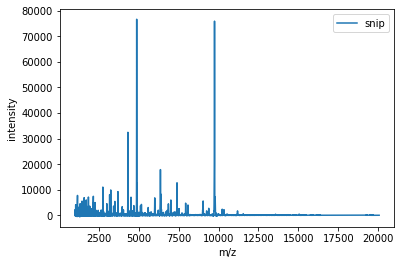

In [12]:
plt.plot(x, y - bkg_4, label='snip')
plt.legend()
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

total peaks=33


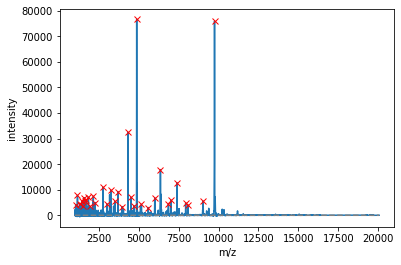

In [13]:
dist, prom = 500, 3000
z =  y - bkg_4
peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)
print(f"total peaks={len(peaks)}")
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, z)
plt.plot(x[peaks], z[peaks], "rx")
plt.plot(x,np.zeros_like(z), "--", color="gray")
plt.show()

In [14]:
for s in range(0,12000,3000):
    n = len([p for p in peaks if s < x[p] < s+3000])
    print(f"[{s},{s+3000}]\t peaks = {n}")

[0,3000]	 peaks = 13
[3000,6000]	 peaks = 11
[6000,9000]	 peaks = 7
[9000,12000]	 peaks = 2


datasets/export/L185_0_A9_1.txt


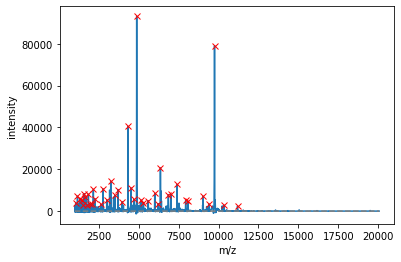

datasets/export/L185_0_A10_1.txt


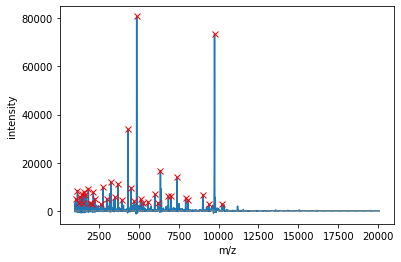

datasets/export/L186_0_A11_1.txt


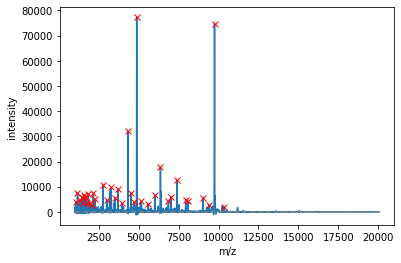

datasets/export/L186_0_A12_1.txt


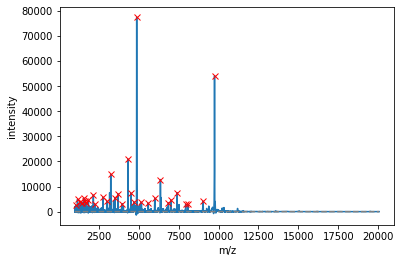

datasets/export/L187_0_B1_1.txt


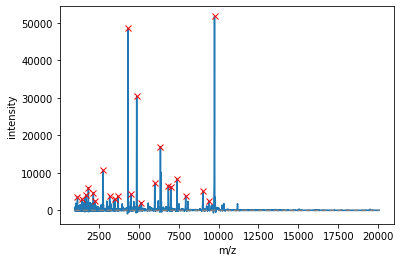

datasets/export/L187_0_B2_1.txt


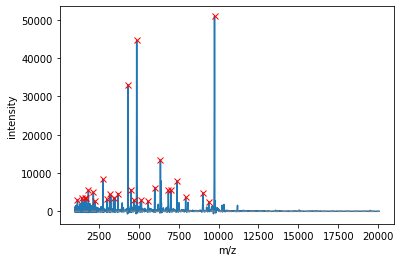

datasets/export/L291_0_A1_1.txt


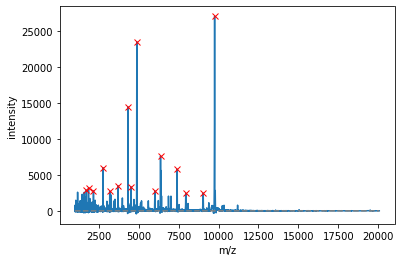

datasets/export/L291_0_A2_1.txt


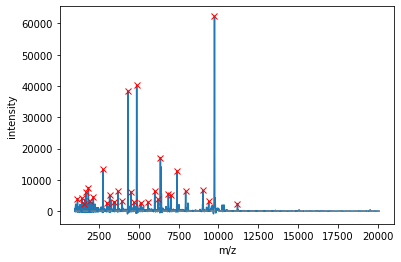

In [15]:
peaks_in = dict()
for file in files:
    print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    window = 15
    deg = 2   
    smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    peaks,_ = signal.find_peaks(smoothed, distance=dist, prominence=prom)

    base_filter = Baseline(x_data=x)
    bkg = base_filter.asls(y, lam=1e7, p=0.02)[0]
    z = smoothed - bkg
    
    peaks_in[file] = zip(x[peaks], z[peaks]) 
    plt.xlabel("m/z")
    plt.ylabel("intensity")
    plt.plot(x, z)
    plt.plot(x[peaks], z[peaks], "rx")
    plt.plot(x, np.zeros_like(y), "--", color="gray")

    plt.show()

In [16]:
for k in peaks_in:
    print(f'{k}:{len(list(peaks_in[k]))}')

L185_0_A9_1:40
L185_0_A10_1:39
L186_0_A11_1:37
L186_0_A12_1:31
L187_0_B1_1:23
L187_0_B2_1:27
L291_0_A1_1:15
L291_0_A2_1:30


In [17]:
from BaselineRemoval import BaselineRemoval

datasets/export/L185_0_A9_1.txt


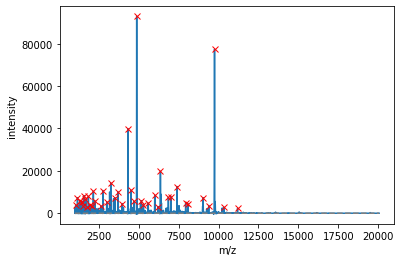

datasets/export/L185_0_A10_1.txt


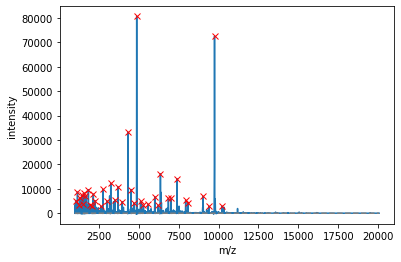

datasets/export/L186_0_A11_1.txt


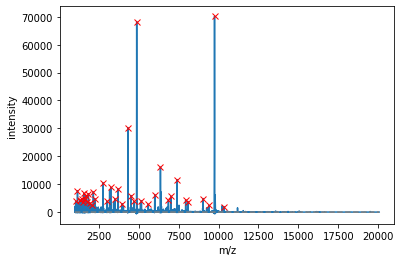

datasets/export/L186_0_A12_1.txt


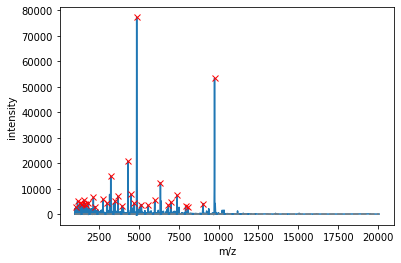

datasets/export/L187_0_B1_1.txt


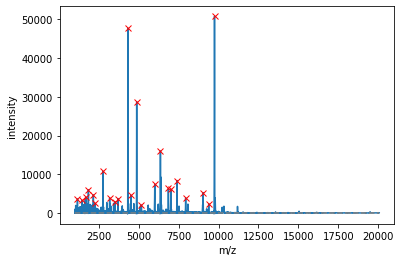

datasets/export/L187_0_B2_1.txt


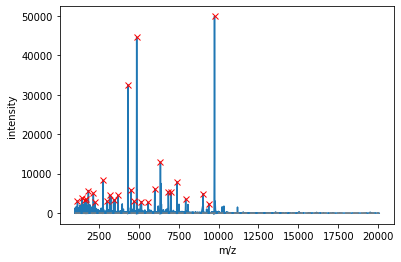

datasets/export/L291_0_A1_1.txt


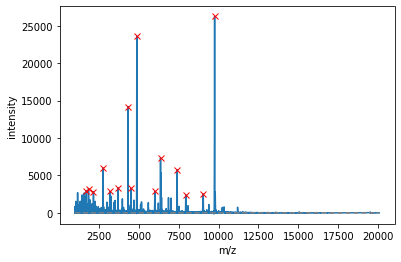

datasets/export/L291_0_A2_1.txt


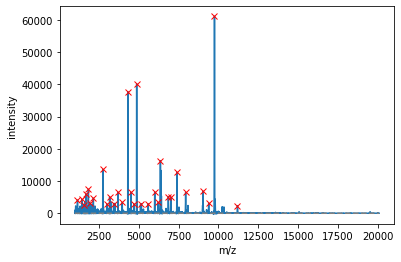

In [20]:
peaks_in = {}
for file in files:
    print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    window = 15
    deg = 2   
    smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    peaks,_ = signal.find_peaks(smoothed, distance=dist, prominence=prom)

    brm = BaselineRemoval(smoothed)
    z = brm.ZhangFit(lambda_=100,repitition=15, porder=1)
    #z = brm.ModPoly(polynomial_degree)
    #z = brm.IModPoly(polynomial_degree)

    peaks_in[file] = (x[peaks], z[peaks]) 
    plt.xlabel("m/z")
    plt.ylabel("intensity")
    plt.plot(x, z)
    plt.plot(x[peaks], z[peaks], "rx")
    plt.plot(x, np.zeros_like(y), "--", color="gray")
    plt.show()

In [21]:
data = []
n = len(files)
for i in range(n-1):
    p1,p2 = files[i], files[i+1]
    print(p1, p2)
    pk1, pk2 = peaks_in[p1], peaks_in[p2]
    pk1, pk2 = dict(zip(pk1[0], pk1[1])), dict(zip(pk2[0],pk2[1]))
    print(pk1.keys() & pk2.keys())
    print("*=" * 10)

L185_0_A9_1 L185_0_A10_1
{1849.766, 4518.752, 9750.626}
*=*=*=*=*=*=*=*=*=*=
L185_0_A10_1 L186_0_A11_1
{2754.762, 4324.595, 4875.104, 6860.881, 1935.547, 3700.047, 9750.626}
*=*=*=*=*=*=*=*=*=*=
L186_0_A11_1 L186_0_A12_1
{2754.762, 7015.626, 7942.37, 2159.707}
*=*=*=*=*=*=*=*=*=*=
L186_0_A12_1 L187_0_B1_1
{6859.885, 6006.203, 2159.707}
*=*=*=*=*=*=*=*=*=*=
L187_0_B1_1 L187_0_B2_1
{2754.604, 7941.298, 4518.146, 9749.438, 6362.121}
*=*=*=*=*=*=*=*=*=*=
L187_0_B2_1 L291_0_A1_1
set()
*=*=*=*=*=*=*=*=*=*=
L291_0_A1_1 L291_0_A2_1
{4324.511, 9750.33}
*=*=*=*=*=*=*=*=*=*=
